# SentinelHub Satellite Data Explorer

Dieses Notebook zeigt, wie man Datensätze von Sentinel Hub herunterlädt, einer Plattform für die Verwaltung und den Zugriff auf Satellitenbilder und Geodaten. Durch die Verwendung der robusten [API](https://dataspace.copernicus.eu/analyse/apis) von Sentinel Hub können Benutzer Satellitenbilder abrufen, verarbeiten und analysieren, die auf spezifische Bedürfnisse zugeschnitten sind. Dies ist besonders wertvoll für Anwendungen wie Umweltüberwachung, Geodatenanalyse und Forschung.

**Schlüsselmerkmale dieses Notebooks:**
* **Zweck**: Zugriff und Download von Satellitenbildern über Sentinel Hub.
* **Anwendungsfälle**: Unterstützung der Datenfilterung und Erstellung verschiedener Indizes.

**Informationen zu Dataest:**
* Quelle: [Sentinelhub](https://sentinelhub-py.readthedocs.io/en/latest/index.html)
* Autor: str.ucture GmbH
* Notebook Version: 1.1 (Aktualisiert: 21. Januar 2025)

## 1. Festlegen der Pfade und Arbeitsverzeichnisse

In [1]:
import os

''' ---- Verzeichnisse hier angeben ---- '''
download_folder = r".\data\sentinelhub\download"
images_folder = r".\data\sentinelhub\images"
''' ----- Ende der Angaben ---- '''

os.makedirs(download_folder, exist_ok=True)
os.makedirs(images_folder, exist_ok=True)

## 2. Filtern der Datensammlung und Abrufen von Satellitenbildern

### 2.1 API und Authentifizierung

Die **Sentinel Hub API** ist eine leistungsstarke RESTful-Schnittstelle, die Zugriff auf Satellitenbilder aus verschiedenen Quellen bietet, wie z. B. **Sentinel**, **Landsat** und anderen Erdbeobachtungsmissionen. Diese API ermöglicht Benutzern:

* Rohe Satellitendaten abrufen
* Statistische Analysen durchführen
* Gerenderte Bilder visualisieren

Diese API wird häufig für Anwendungen in Bereichen wie Landwirtschaft, Forstwirtschaft, Umweltüberwachung und mehr verwendet.

#### Authentifizierung mit OAuth2

Für die Interaktion mit der Sentinel Hub API ist eine **OAuth2**-Authentifizierung erforderlich. Befolgen Sie diese Schritte, um Ihre Anmeldeinformationen einzurichten und sich zu authentifizieren:

1. **Konto registrieren**
- Besuchen Sie das [Copernicus Data Space Ecosystem](https://dataspace.copernicus.eu/) und erstellen Sie ein Konto.
- Melden Sie sich nach der Registrierung bei Ihrem Konto an.

2. **Erstellen Sie einen OAuth-Client**
- Lesen Sie den [OAuth-Client-Registrierungsleitfaden](https://docs.sentinel-hub.com/api/latest/api/overview/authentication/#registering-oauth-client).
- Generieren Sie eine „Client-ID“ und ein „Client-Geheimnis“ für Ihre Anwendung.

Alternativ gehen Sie zu [Dashboard](https://shapps.dataspace.copernicus.eu/dashboard/#/) > Benutzereinstellungen > Wählen Sie unter OAuth-Clients **+ Erstellen**. > Füllen Sie die Informationen aus und klicken Sie auf Erstellen. Dadurch erhalten Sie Ihre „Client-ID“ und Ihr „Client-Geheimnis“.

3. **Verwenden Sie Anmeldeinformationen für Zugriffstoken**
- Verwenden Sie die „Client-ID“ und das „Client-Geheimnis“, um Zugriffstoken anzufordern, die zur Authentifizierung und Autorisierung Ihrer API-Anfragen erforderlich sind.
- Ersetzen Sie die Platzhalterwerte „Client-ID“ und „Client-Geheimnis“ im folgenden Code durch Ihre tatsächlichen Anmeldeinformationen.

4. **Einmalige Authentifizierung**
- Die Authentifizierung ist nur einmal pro Computersystem erforderlich. Nachdem Sie Ihre Anmeldeinformationen eingerichtet und authentifiziert haben, können Sie mit den nächsten Schritten fortfahren, ohne den Vorgang zu wiederholen.

#### Schnellzugriffe:
- **Konto registrieren**: [Copernicus Data Space Ecosystem](https://dataspace.copernicus.eu/)
- **OAuth-Client-Setup**: [OAuth-Client-Handbuch](https://docs.sentinel-hub.com/api/latest/api/overview/authentication/#registering-oauth-client)

In [2]:
# # Entfernen Sie die Kommentarzeichen und führen Sie diese Zelle nur aus, wenn:
# # - Sie diesen Code zum ersten Mal ausführen UND
# # - Sie keine Konfiguration erstellt haben.

# from sentinelhub import SHConfig

# # Initialisieren Sie die Sentinel Hub-Konfiguration
# config = SHConfig()

# # Ersetzen Sie die Platzhalter unten durch Ihre tatsächliche Client-ID und Ihr Client-Geheimnis
# config.sh_client_id = 'Ihre-Client-ID-hier' # Beispiel: '1234abcd-5678-efgh-ijkl-9876mnopqrst'
# config.sh_client_secret = 'Ihr-Client-Geheimnis-hier' # Beispiel: 'a1b2c3d4e5f6g7h8i9j0klmnopqrst'

# # Legen Sie die Basis-URL und die Token-URL für das Copernicus Data Space Ecosystem fest
# config.sh_base_url = 'https://sh.dataspace.copernicus.eu'
# config.sh_token_url = 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token'

# # Speichern Sie die Konfiguration in einer Datei mit dem Namen „cdse“
# config.save("cdse")

In [3]:
# Erforderliche Module von SentinelHub importieren
from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubCatalog,
    SentinelHubRequest,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
    MosaickingOrder,
)

# Laden Sie die Konfiguration aus der Datei "cdse".
config = SHConfig("cdse")

# Prüfen Sie, ob die Konfiguration richtig geladen wurde.
if not config.sh_client_id or not config.sh_client_secret:
    raise ValueError(
        "Die Konfigurationsdatei 'cdse' fehlt oder ist unvollständig. "
        "Stellen Sie sicher, dass Sie sie mit einer gültigen 'Client-ID' und 'Client-Secret' erstellt haben."
    )

### 2.2 Definieren von Datenabfrageparametern

Sie können Satellitendaten mithilfe verschiedener Parameter filtern, um die Ergebnisse basierend auf Ihrem Interessensgebiet und spezifischen Analysebedürfnissen einzugrenzen. Einige der wichtigsten Parameter umfassen:

1. **Grenzen der Bounding Box**: Definieren Sie ein geografisches Interessensgebiet, indem Sie Koordinaten angeben.
2. **Datenbereich**: Filtern Sie die Daten, indem Sie ein Start- und Enddatum angeben.
3. **Wolkenbedeckung**: Beschränken Sie das Datenset auf Bilder mit einem bestimmten Bereich von Wolkenbedeckung.
4. **Auswertungsskripte**: Verwenden Sie benutzerdefinierte Skripte, um spezifische Bänder zu filtern oder zu verarbeiten, was für fortgeschrittene Anwendungsfälle nützlich ist. (Siehe Abschnitt 3.1 für Details.)

#### 1. Grenzen der Bounding Box

In [4]:
# Definieren Sie die Grenzen der Bounding Box im CRS: WGS84 Format [lon_min, lat_min, lon_max, lat_max]
# Beispiel: Bounding Box für Konstanz, Deutschland: [lon_min, lat_min, lon_max, lat_max]

bbox_wgs84 = [9.1170, 47.6330, 9.2180, 47.7160]  # Bounding Box für Konstanz, Deutschland
resolution = 10  # Die primären Bänder von Sentinel-2 haben eine räumliche Auflösung von 10 m

# Erstellen Sie ein BBox-Objekt und berechnen Sie die Dimensionen der Bounding Box basierend auf der Auflösung
aoi_bbox = BBox(bbox=bbox_wgs84, crs=CRS.WGS84)
aoi_size = bbox_to_dimensions(aoi_bbox, resolution=resolution)

# Referenzdokumentation für Sentinel-2 Bänder und Auflösung
# Mehr erfahren: https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l1c/


> Alternativ, falls Sie sich unsicher bezüglich der Grenzen der Bounding Box sind, können Sie diese Website verwenden, um interaktiv eine Bounding Box auf einer Karte zu zeichnen: https://str-ucture.github.io/bbox-extractor/

*Dieses Tool ermöglicht es Ihnen, Ihr Interessensgebiet visuell zu definieren und die Koordinaten der Bounding Box zu extrahieren, mit der Option, die gewünschte Präzision festzulegen.*

---

<div style="transform: scale(0.85); transform-origin: top left; width: 1000px; height: 700px;"> <iframe src="https://str-ucture.github.io/bbox-extractor/" title="bbox-extractor" style="width: 100%; height: 110%;"></iframe> </div>

---

#### 2. Datumsbereich

In [5]:
import ipywidgets as widgets
import datetime

# Erstellen Sie ein DatePicker-Widget zur Auswahl des Startdatums
initial_date = widgets.DatePicker(
    description="Startdatum auswählen: ",
    style=dict(description_width='initial'),
    disabled=False,
    value=datetime.date(2024,1,1)
    )

# Anzeigen des DatePicker-Widgets
display(initial_date)

DatePicker(value=datetime.date(2024, 1, 1), description='Startdatum auswählen: ', step=1, style=DescriptionSty…

In [6]:
# Erstellen Sie ein DatePicker-Widget zur Auswahl des Enddatums
final_date = widgets.DatePicker(
    description="Enddatum auswählen: ",
    style=dict(description_width='initial'),
    disabled=False,
    value=datetime.date.today()
)

# Anzeigen des DatePicker-Widgets
display(final_date)

DatePicker(value=datetime.date(2025, 2, 21), description='Enddatum auswählen: ', step=1, style=DescriptionStyl…

In [7]:
# Sicherstellen, dass das Zeitintervall nur festgelegt wird, wenn beide Daten gültige Werte haben
if initial_date.value and final_date.value:
    # Erstellen Sie ein Tupel für das Zeitintervall mit den ausgewählten Start- und Enddaten
    time_interval = (str(initial_date.value), str(final_date.value))
    print(f"Zeitintervall erfolgreich festgelegt: {time_interval}")
else:
    # Fehler auslösen, wenn eines der Daten fehlt
    raise ValueError("Sowohl das Start- als auch das Enddatum müssen ausgewählt werden, um das Zeitintervall zu definieren.")

Zeitintervall erfolgreich festgelegt: ('2024-01-01', '2025-02-21')


#### 3. Wolkenbedeckung

In [8]:
# Erstellen Sie ein BoundedIntText-Widget zur Angabe des Prozentsatzes der Wolkenbedeckung
cloud_cover_input = widgets.BoundedIntText(
    value=20,
    min=0,
    max=100,
    step=10,
    description="Wolkenbedeckung (%):",
    style={"description_width": "initial"},
)

# Anzeigen des Widgets für die Wolkenbedeckung
display(cloud_cover_input)


BoundedIntText(value=20, description='Wolkenbedeckung (%):', step=10, style=DescriptionStyle(description_width…

### 2.3 Abrufen des gefilterten Datensatzes mit SentinelHubCatalog

Der **SentinelHubCatalog** ist ein leistungsstarkes Tool innerhalb der Sentinel Hub API, das es Nutzern ermöglicht, Metadaten für Satellitenbilddatensätze zu suchen und abzurufen. Es bietet erweiterte Filterfunktionen basierend auf verschiedenen Parametern, wie zum Beispiel:

* **Zeitraum**: Filter nach spezifischen Daten oder Zeitintervallen.
* **Interessensgebiet (AoI)**: Definieren Sie die geografische Region für den Datensatz.
* **Bewölkungsgrad**: Filter für Bilder basierend auf dem Prozentsatz der Bewölkung.
* **Datensammlungstypen**: Wählen Sie aus verschiedenen Datensammlungen (z.B. Sentinel-2, Landsat).

*Dieses Tool vereinfacht den Prozess der Identifizierung und Abrufung relevanter Bilder, indem es eine effiziente Filterung basierend auf diesen Kriterien ermöglicht.*

In [9]:
import pandas as pd

# Initialisiere das SentinelHubCatalog mit der Konfiguration
catalog = SentinelHubCatalog(config=config)

# Suche die Sentinel-2 L2A Datensammlung mit den definierten Parametern
search_iterator = catalog.search(
    DataCollection.SENTINEL2_L2A,
    bbox=aoi_bbox,
    time=time_interval,
    filter=f"eo:cloud_cover <= {cloud_cover_input.value}",
)

# Konvertiere die Suchergebnisse in eine Liste
results = list(search_iterator)
print("Gesamtanzahl der Ergebnisse:", len(results))

# Verarbeite die Ergebnisse in eine strukturierte Liste von Dictionaries
data = []
for entry in results:
    id = entry['id']
    dt = entry['properties']['datetime']
    date, time = dt.split('T')
    time = time.replace('Z', '')
    cloud_cover = entry['properties']['eo:cloud_cover']
    data.append({
        'Datum':date,
        'Zeit':time,
        'Bewölkungsgrad (%)':cloud_cover,
        'Id':id,}),
    
# Konvertiere die Liste in ein Pandas DataFrame und zeige die ersten 5 Zeilen an
df = pd.DataFrame(data).sort_values(by='Bewölkungsgrad (%)').reset_index(drop=True)
df.head(8)

Gesamtanzahl der Ergebnisse: 43


Datum          Zeit  Bewölkungsgrad (%)  \
0  2024-09-07  10:27:40.714                0.00   
1  2024-09-07  10:27:39.135                0.04   
2  2024-08-23  10:27:45.974                0.08   
3  2024-02-03  10:37:36.934                0.08   
4  2024-12-16  10:27:44.705                0.09   
5  2024-02-03  10:37:41.626                0.16   
6  2024-12-16  10:28:16.069                0.33   
7  2024-08-23  10:27:44.048                0.37   

                                                  Id  
0  S2A_MSIL2A_20240907T102021_N0511_R065_T32TMT_2...  
1  S2A_MSIL2A_20240907T102021_N0511_R065_T32TNT_2...  
2  S2B_MSIL2A_20240823T101559_N0511_R065_T32TMT_2...  
3  S2A_MSIL2A_20240203T103231_N0510_R108_T32TNT_2...  
4  S2A_MSIL2A_20241216T102431_N0511_R065_T32TMT_2...  
5  S2A_MSIL2A_20240203T103231_N0510_R108_T32TMT_2...  
6  S2C_MSIL2A_20241216T102501_N9905_R065_T32TMT_2...  
7  S2B_MSIL2A_20240823T101559_N0511_R065_T32TNT_2...

In [10]:
# Zusätzliche Filterung, um nur die Bilder aus den Sommermonaten (Juni, Juli und August) auszuwählen
df['Datum'] = pd.to_datetime(df['Datum'])
filtered_df = df[df['Datum'].dt.month.isin([6, 7, 8])].reset_index(drop=True)
filtered_df.head(8)

Datum          Zeit  Bewölkungsgrad (%)  \
0 2024-08-23  10:27:45.974                0.08   
1 2024-08-23  10:27:44.048                0.37   
2 2024-08-11  10:37:42.547                0.87   
3 2024-08-06  10:37:43.937                1.16   
4 2024-08-28  10:27:47.301                1.45   
5 2024-06-19  10:27:54.375                1.50   
6 2024-06-19  10:27:50.587                3.44   
7 2024-08-06  10:37:48.665                8.07   

                                                  Id  
0  S2B_MSIL2A_20240823T101559_N0511_R065_T32TMT_2...  
1  S2B_MSIL2A_20240823T101559_N0511_R065_T32TNT_2...  
2  S2A_MSIL2A_20240811T103031_N0511_R108_T32TNT_2...  
3  S2B_MSIL2A_20240806T102559_N0511_R108_T32TNT_2...  
4  S2A_MSIL2A_20240828T102021_N0511_R065_T32TMT_2...  
5  S2A_MSIL2A_20240619T102031_N0510_R065_T32TMT_2...  
6  S2A_MSIL2A_20240619T102031_N0510_R065_T32TNT_2...  
7  S2B_MSIL2A_20240806T102559_N0511_R108_T32TMT_2...

## 3. Download und Visualisierung von Satellitendaten

### 3.1 Evaluierungsskripte

Evaluierungsskripte **(evalscript)** in der Sentinel Hub API werden verwendet, um die Verarbeitung und Visualisierung von Satellitenbilddaten anzupassen. Diese Skripte ermöglichen es, Bänder auszuwählen, Indizes zu berechnen (z.B. NDVI), benutzerdefinierte Visualisierungen anzuwenden und Daten zu filtern oder zu maskieren. Sie werden serverseitig ausgeführt, um verarbeitete Ausgaben zu liefern, wie zum Beispiel Bilder oder numerische Werte, die auf die spezifischen Bedürfnisse des Nutzers abgestimmt sind. Durch die Verwendung von Evaluierungsskripten können Sie die Datenverarbeitung optimieren und sich auf die präzisen Informationen konzentrieren, die für die Fernerkundungsanalyse oder -anwendungen erforderlich sind.

> **Wichtig: Modifizieren Sie die Evaluierungsskripte nicht, es sei denn, Sie sind sich Ihrer Änderungen sicher.**

In [11]:
evalscript_sentinel2_all_bands = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"],
                units: "DN"
            }],
            output: {
                bands: 13,
                sampleType: "INT16"
            }
        };
    }
    function evaluatePixel(sample) {
        return [sample.B01, 
                sample.B02,
                sample.B03,
                sample.B04,
                sample.B05,
                sample.B06,
                sample.B07,
                sample.B08,
                sample.B8A,
                sample.B09,
                sample.B10,
                sample.B11,
                sample.B12];
    }
"""

### 3.2 Anfordern von Satellitendaten und Erstellen von Diagrammen

#### 1. Anfordern der Datensammlung und Abrufen des Satellitenbildes mit dem geringsten Bewölkungsgrad (Least_CC)

> Hinweis: Die Methode Least_CC hilft dabei, die Datenqualität zu optimieren, insbesondere wenn die Bewölkung die Klarheit des Bildes beeinträchtigen kann. Stellen Sie sicher, dass Sie dies in Ihrer Anfrage angeben, um die Chancen auf klare Bilder zu maximieren.

In [12]:
# Definiere eine Anfrage, um alle Sentinel-2 Bänder herunterzuladen
request_all_bands = SentinelHubRequest(
    data_folder = download_folder,
    evalscript=evalscript_sentinel2_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C.define_from(
                "s2l1c",
                service_url=config.sh_base_url
            ),
            time_interval=time_interval,
            mosaicking_order=MosaickingOrder.LEAST_CC,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config,
)

# Anfrage stellen und die Daten abrufen (ohne sie lokal zu speichern)
all_bands_response = request_all_bands.get_data(save_data=False)

#### 2. Zeichnen Sie ein True Color-Raster mit **Matplotlib**

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Any, Optional, Tuple

def plot_image(
    image: np.ndarray,
    factor: float = 1.0,
    clip_range: Optional[Tuple[float, float]] = None,
    figsize: Tuple[float, float] = (15, 15),
    show_axis: bool = False,  # Hinzugefügte Option, Achsen anzuzeigen
    **kwargs: Any
) -> None:
    """
    Hilfsfunktion zum Anzeigen von RGB-Bildern.

    Parameter:
        bild (np.ndarray): Das Bildarray zum Anzeigen. Erwartete Form ist (Höhe, Breite, Kanäle).
        faktor (float, optional): Skalierungsfaktor zur Anpassung der Bildintensität. Standard ist 1.0.
        clip_bereich (Tuple[float, float], optional): Bereich zum Schneiden der Bildintensitätswerte.
            Wenn angegeben, werden die Bildwerte auf diesen Bereich zugeschnitten.
        figsize (Tuple[float, float], optional): Größe der Figur in Zoll. Standard ist (15, 15).
        achse_anzeigen (bool, optional): Ob Achsenticks angezeigt werden sollen. Standard ist False.
        **kwargs (Any): Weitere Schlüsselwortargumente, die an plt.imshow übergeben werden.

    Rückgabewert:
        None: Die Funktion zeigt das Bild mit matplotlib an.
    """
    # Erstelle eine Figur und Achse für die Darstellung
    fig, ax = plt.subplots(figsize=figsize)
    
    # Wende Skalierung und optionales Clipping auf das Bild an
    image_to_display = np.clip(image * factor, *clip_range) if clip_range is not None else image * factor
    
    # Zeige das Bild an
    ax.imshow(image_to_display, **kwargs)
    
    # Entferne bedingt die Achsenticks für eine sauberere Bilddarstellung
    if not show_axis:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')

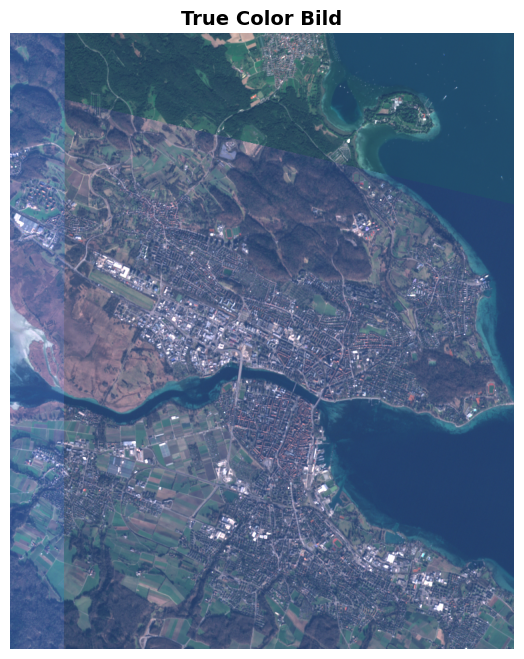

In [14]:
# Abrufen des ersten Bildes aus der all_bands_response
image = all_bands_response[0]

# Berechne den Intensitätsbereich für Skalierung und Clipping
min_val = np.percentile(image, 2) # 2. Perzentil für den unteren Grenzwert
max_val = np.percentile(image, 98) # 98. Perzentil für den unteren Grenzwert

# Berechne den Skalierungsfaktor basierend auf dem maximalen Wert
factor = 1.0 / max_val

# Wende einen Multiplikator an, um die Intensität weiter anzupassen
factor_multiplier = 1.4

# Zeige das Bild in echten Farben (RGB) unter Verwendung des berechneten Skalierungsfaktors an
plot_image(
    image[:, :, [3, 2, 1]], # Band-Indizes für Rot, Grün und Blau (B04, B03, B02)
    factor=factor * factor_multiplier, # Wende Faktor und Multiplikator zur Skalierung der Intensität an
    clip_range=(0, 1), # Schneide die Intensität auf den Bereich [0, 1]
    figsize=(8, 8)
)

# Setze den Titel für das Diagramm
plt.title("True Color Bild", fontsize=14, fontweight='bold')
plt.show()

Manchmal können die Anforderungsparameter—wie der Zeitraum und die `mosaicking_order`—zu schlechter Qualität oder unerwünschten Mosaik-Satellitendaten führen. In solchen Fällen kann es notwendig sein, das Zeitintervall manuell anzupassen, um sicherzustellen, dass die gewünschten Satellitenbilder abgerufen werden. Weitere Details dazu, wie der Zeitraum geändert werden kann, finden Sie in Abschnitt 2.3.

Zusätzlich ist die Möglichkeit, direkt auf Satellitendaten über eine spezifische Bild-ID zuzugreifen, eine wertvolle Funktion mit großem Potenzial. Diese Funktion sollte weiter untersucht werden, um ihre Möglichkeiten vollständig zu verstehen und wie sie effektiv implementiert werden kann.

In [15]:
# Beispiel: Fordere Daten für die angegebenen Parameter in der Tabelle "df" an

# Definiere das Zeitintervall (ändern Sie es basierend auf den spezifischen Anforderungen)
time_interval = '2024-08-23' # Passen Sie diesen Wert an, um nach dem gewünschten Datumsbereich zu filtern

# Fordere Satellitendaten basierend auf den angegebenen Parametern an
request_all_bands = SentinelHubRequest(
    data_folder=download_folder,
    evalscript=evalscript_sentinel2_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C.define_from(
                "s2l1c", service_url=config.sh_base_url
            ),
            time_interval=time_interval,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config,
)

# Abrufen der Satellitendaten
all_bands_response_v2 = request_all_bands.get_data(save_data=False) # Ändern Sie save_data=True, um die Daten lokal zu speichern

In [16]:
# Speichere das Bild mit allen Bändern lokal
all_bands_response_v3 = request_all_bands.get_data(save_data=True)

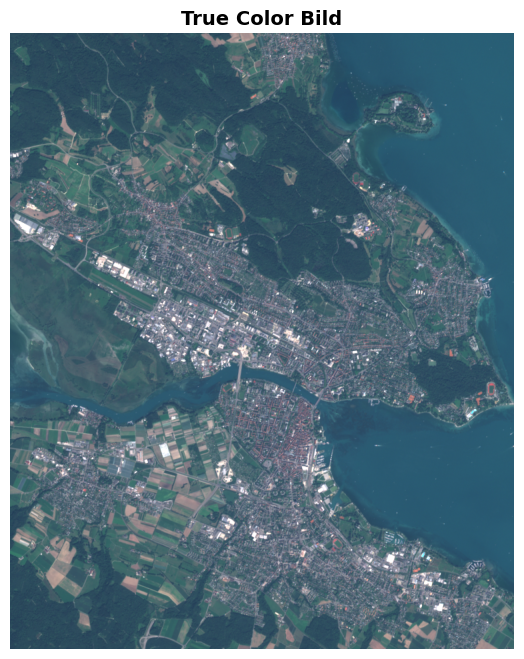

In [17]:
# Abrufen des ersten Bildes aus den Antwortdaten
image = all_bands_response_v2[0]

# Berechne den Intensitätsbereich, Skalierungsfaktor und passe die Helligkeit an
min_val = np.percentile(image, 2)
max_val = np.percentile(image, 98)
factor = 1.0 / max_val
factor_multiplier = 1.6

# Zeige das Bild in echten Farben (RGB) unter Verwendung des angegebenen Skalierungs- und Clipping-Bereichs an
plot_image(
    image[:, :, [3, 2, 1]],
    factor=factor * factor_multiplier,
    clip_range=(0, 1),
    figsize=(8, 8)
)

# Setze den Titel für das Diagramm
plt.title("True Color Bild", fontsize=14, fontweight='bold')
plt.show()

## 4. Speichern des Bildes als GeoTIFF-Raster

Eine effektive Methode zur Visualisierung und Wahrung der Integrität von Sentinel-2-Datensätzen besteht darin, sie lokal als GeoTIFF-Datei zu speichern. GeoTIFF ist ein weit verbreitetes Format, das nicht nur die Bilddaten, sondern auch wichtige geospatiale Metadaten wie geografische Koordinaten, Projektionsinformationen und andere Eigenschaften beibehält. Dies macht es ideal für die weitere Analyse in GIS-Software wie QGIS, ArcGIS oder anderen geospatialen Tools.

Das Speichern Ihres Bildes in diesem Format stellt sicher, dass Sie die Bilddaten problemlos laden, bearbeiten und visualisieren können, während die räumliche Referenz beibehalten wird.

In [18]:
import rasterio
from rasterio.transform import from_bounds
from PIL import Image

# Definiere die Form und Transformationsparameter basierend auf den Bildabmessungen
height, width, bands = image.shape
transform = from_bounds(*bbox_wgs84, width=width, height=height)

# Extrahiere die RGB-Bänder (Rot, Grün, Blau) und bereite das Bild vor
rgb_image = image[:, :, [3, 2, 1]]
clipped_image = np.clip(rgb_image * factor * factor_multiplier, 0, 1)
uint8_image = (clipped_image * 255).astype(np.uint8)

# Definiere die Pfade zum Speichern der Bilder
temp_tif = os.path.join(images_folder, f"sentinel2_all_bands_{time_interval}.tif")
temp_png = os.path.join(images_folder, f"sentinel2_rgb_{time_interval}.png")

# Stelle sicher, dass der Download-Ordner existiert
os.makedirs(images_folder, exist_ok=True)

# Speichere das Bild als GeoTIFF, wenn es noch nicht existiert
if not os.path.isfile(temp_tif):
    with rasterio.open(
        temp_tif,
        "w",
        driver="GTiff",
        height=height,
        width=width,
        count=3, # Nur 3 Bänder für RGB
        dtype=uint8_image.dtype,
        crs="EPSG:4326",  # WGS84 coordinate reference system
        transform=transform,
    ) as dst:
        for i in range(3): # Schleife durch die RGB-Bänder
            dst.write(uint8_image[:, :, i], i + 1)
    print(f"GeoTIFF gespeichert unter: {temp_tif}")
else:
    print(f"GeoTIFF-Datei existiert bereits unter: {temp_tif}")
    
# Speichere das Bild als PNG-Datei
if not os.path.isfile(temp_png):
    # Konvertiere das RGB-Array in das PIL-Bildformat und speichere es als PNG
    pil_image = Image.fromarray(uint8_image, mode="RGB")
    pil_image.save(temp_png)
    print(f"PNG gespeichert unter: {temp_png}")
else:
    print(f"PNG-Datei existiert bereits unter: {temp_png}")

GeoTIFF-Datei existiert bereits unter: .\data\sentinelhub\images\sentinel2_all_bands_2024-08-23.tif
PNG-Datei existiert bereits unter: .\data\sentinelhub\images\sentinel2_rgb_2024-08-23.png


## 5. Visualisiere das Raster

### 5.1 Visualisiere das gespeicherte True Color Raster mit **Folium**

Sobald das True Color Raster als GeoTIFF-Datei gespeichert wurde, kann es einfach mit **Folium** visualisiert werden.


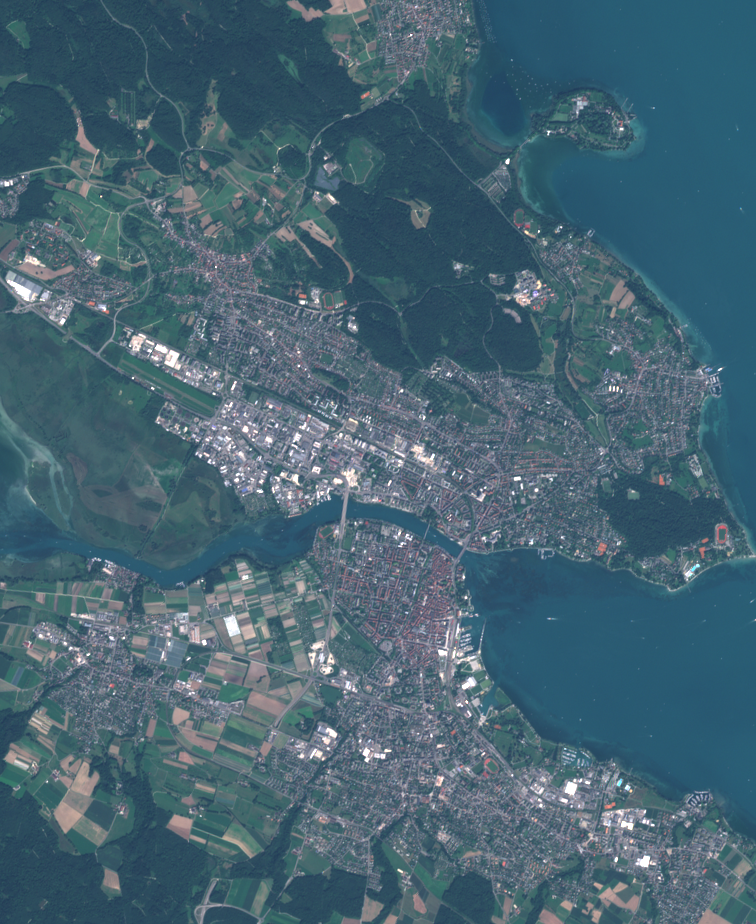

In [19]:
import folium
from folium.plugins import MiniMap, Fullscreen

# Erstelle eine Folium-Karte, die auf der Bounding Box zentriert ist
m = folium.Map(
    location=[(bbox_wgs84[1] + bbox_wgs84[3])/2, (bbox_wgs84[0] + bbox_wgs84[2])/2],
    zoom_start=12,
    scrollWheelZoom=False
    )

# Definiere die Grenzen des Bildes in Breitengrad/Längengrad
bounds_latlon = [[bbox_wgs84[1], bbox_wgs84[0]], [bbox_wgs84[3], bbox_wgs84[2]]]

# Füge eine Raster-Überlagerung für das gespeicherte PNG-Bild hinzu (alternativ kann auch GeoTIFF verwendet werden)
temp_png_filename = (os.path.basename(temp_png).split(".")[0])
folium.raster_layers.ImageOverlay(
    name=f"{temp_png_filename}",
    image=temp_png,
    bounds=bounds_latlon,
    opacity=1.0,
).add_to(m)

# Füge eine Layer-Steuerung hinzu (zum Umschalten zwischen den Layern)
folium.LayerControl().add_to(m)

# Füge MiniMap und Fullscreen-Steuerelemente hinzu
MiniMap(toggle_display=True, minimized=True).add_to(m)
Fullscreen().add_to(m)

# Zeige die Karte an
m

### 5.2 Visualisiere ein False-Color-Komposit mit **Matplotlib**

False-Color-Komposits heben bestimmte Merkmale in Satellitenbildern hervor, wie z. B. Vegetation, Gewässer und städtische Gebiete, indem sie den nicht sichtbaren spektralen Bändern verschiedene Farben zuweisen. Diese Methode ist besonders nützlich für die Analyse der Landnutzung, der Vegetationsgesundheit (mit Bändern wie NIR und Red Edge) und anderen Umweltfaktoren.

Weitere Informationen zu benutzerdefinierten Komposit-Skripten und deren Anwendungsfällen finden Sie im offiziellen [Sentinel Hub Custom Scripts Repository](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/composites/).


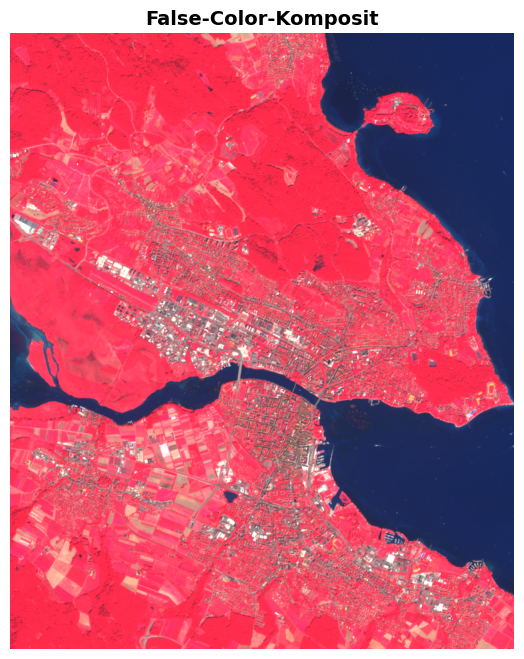

In [20]:
# Plotte ein False-Color-Komposit unter Verwendung spezifischer Bänder: 
# Band 7 (NIR), Band 3 (Rot), Band 2 (Grün) zur Vegetationsanalyse
plot_image(
    image[:, :, [7, 3, 2]], # NIR (Band 7), Rot (Band 3), Grün (Band 2)
    factor=factor*factor_multiplier,
    clip_range=(0, 1),
    figsize=(8, 8)
)

# Setze den Titel für das Diagramm
plt.title("False-Color-Komposit", fontsize=14, fontweight='bold')
plt.show()

### 5.3 Berechne und Plotte Remote Sensing **Indizes** (Indices)

Remote Sensing Indizes, wie der Normalized Difference Vegetation Index (NDVI), der Normalized Difference Water Index (NDWI) und andere, werden häufig verwendet, um verschiedene Umweltfaktoren wie Vegetationsgesundheit, Gewässer und Landbedeckung zu analysieren.

Für weitere Informationen zur Berechnung und Nutzung dieser Indizes können Sie das offizielle [Sentinel Hub Custom Scripts Repositiry](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel/sentinel-2/#popular-rgb-composites) besuchen.

#### 1 Normalized Difference Vegetation Index (NDVI)

Der Normalized Difference Vegetation Index (NDVI) misst die Pflanzenhealth und Biomasse. Er wird häufig verwendet, um das Wachstum und die Gesundheit der Vegetation zu überwachen sowie Gebiete mit Stress oder Schäden zu identifizieren.

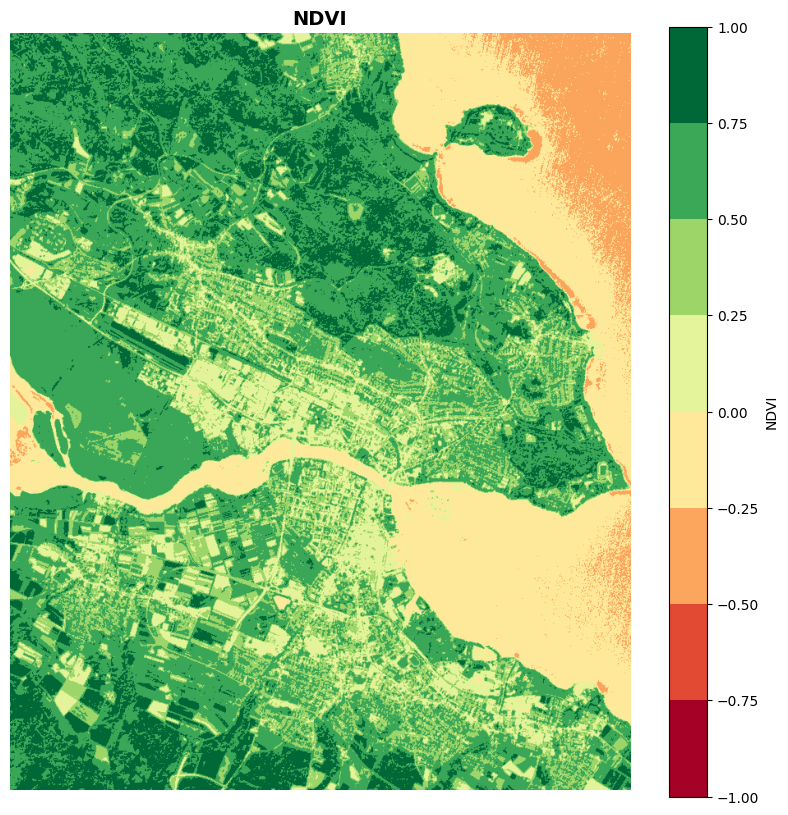

In [21]:
# Extrahiere das NIR (Band 8) und das Rote (Band 4) Band aus den Satellitendaten
nir = all_bands_response_v2[0][:, :, 7]  # Band 8 (NIR)
red = all_bands_response_v2[0][:, :, 3]  # Band 4 (Rot)

# Berechne den NDVI (füge eine kleine Zahl zum Nenner hinzu, um Division durch Null zu vermeiden)
ndvi = (nir - red) / (nir + red + 1e-10)

# Plotte den NDVI
plt.figure(figsize=(10, 10))
cmap = plt.get_cmap('RdYlGn',8)
plt.imshow(ndvi, cmap=cmap, vmin=-1, vmax=1)

# Füge eine Farbskala hinzu
plt.colorbar(label='NDVI')

# Setze den Titel und entferne die Achsenbeschriftungen
plt.title('NDVI', fontsize=14, fontweight='bold')
plt.axis('off')

# Zeige das Plot an
plt.show()

#### 2 Normalized Difference Moisture Index (NDMI)

Der Normalized Difference Moisture Index (NDMI) ist ein wichtiger Indikator zur Überwachung des Wassergehalts in der Vegetation. Er hilft dabei, die Pflanzenhealth zu bewerten, Trockenstress zu erkennen und die Effizienz der Bewässerung zu evaluieren.

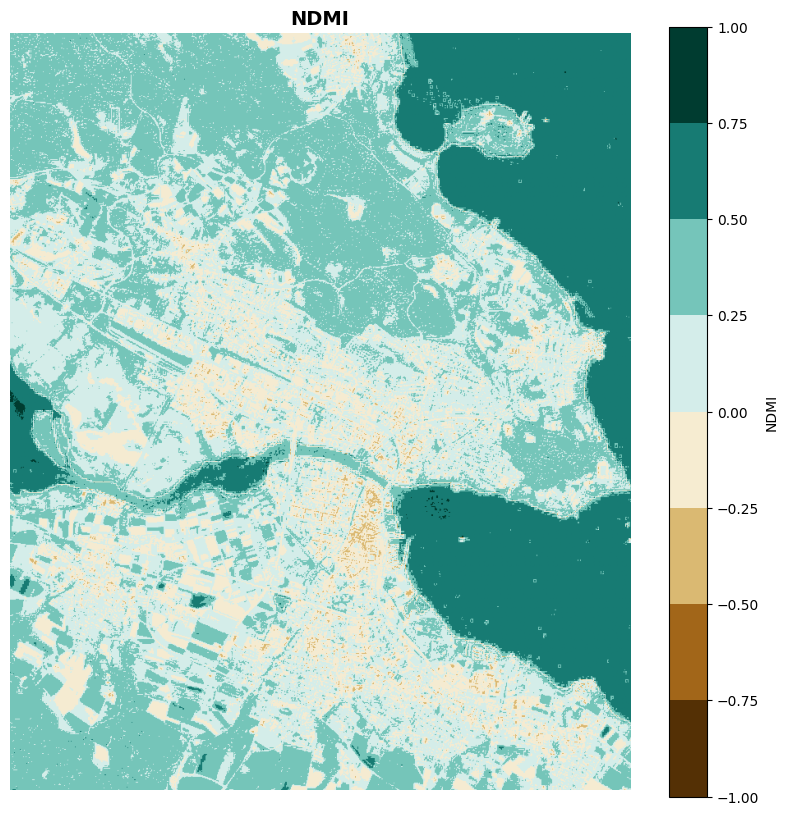

In [22]:
# Extrahiere das NIR (Band 8) und SWIR (Band 12) Band aus den Satellitendaten
nir = all_bands_response_v2[0][:, :, 7] # Band 8 (NIR)
swir = all_bands_response_v2[0][:, :, 11] # Band 12 (SWIR)

# Berechne den NDMI (füge eine kleine Zahl zum Nenner hinzu, um Division durch Null zu vermeiden)
ndmi = (nir - swir) / (nir + swir + 1e-10)

# Plotte den NDMI
plt.figure(figsize=(10, 10))
cmap = plt.get_cmap('BrBG', 8) # Angepasste Farbkarte für NDMI
plt.imshow(ndmi, cmap=cmap, vmin=-1, vmax=1)

# Füge eine Farbskala hinzu
plt.colorbar(label='NDMI')

# Setze den Titel und entferne die Achsenbeschriftungen
plt.title('NDMI', fontsize=14, fontweight='bold')
plt.axis('off')

# Zeige das Plot an
plt.show()

#### 3 Albdo

Albedo ist ein Maß für die Reflektivität einer Oberfläche, das angibt, wie viel Sonnenlicht von einer Oberfläche reflektiert wird im Vergleich dazu, wie viel absorbiert wird. Es ist entscheidend für das Verständnis des Energiehaushalts der Oberfläche, der Wärmeverteilung und der Eigenschaften der Landbedeckung. In der Fernerkundung wird Albedo häufig verwendet, um Veränderungen in den Oberflächenmerkmalen wie Schneedecke, Vegetation oder Urbanisierung zu untersuchen.

Albedo-Werte reichen von 0 (keine Reflexion, totale Absorption) bis 1 (totale Reflexion), wobei ein höheres Albedo auf reflektierende Oberflächen (wie Schnee oder Eis) hinweist und ein niedrigeres Albedo auf dunklere Oberflächen (wie Wälder oder Ozeane).

Referenz: [Albedo Retrieval From Sentinel-2](https://doi.org/10.1109/LGRS.2020.2967085)

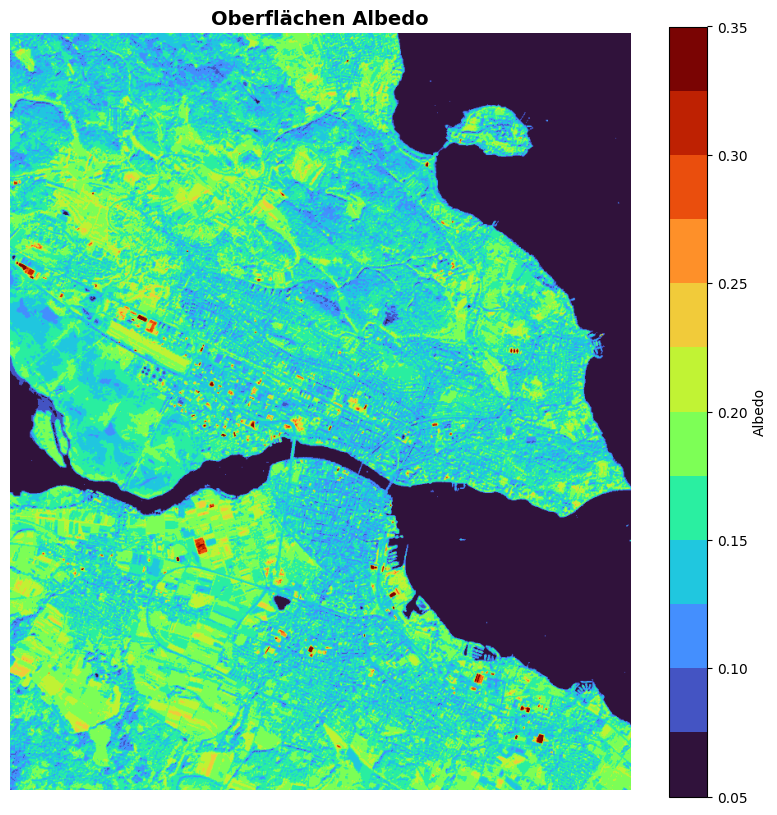

In [23]:
# Extrahieren der Bänder und Umwandeln von DN in Reflektanz (DN = 10000 * REFLEKTANZ)
B02 = all_bands_response_v2[0][:, :, 1] / 10000.0  # Blau
B03 = all_bands_response_v2[0][:, :, 2] / 10000.0  # Grün
B04 = all_bands_response_v2[0][:, :, 3] / 10000.0  # Rot
B08 = all_bands_response_v2[0][:, :, 7] / 10000.0  # NIR
B11 = all_bands_response_v2[0][:, :, 11] / 10000.0 # SWIR1
B12 = all_bands_response_v2[0][:, :, 12] / 10000.0 # SWIR2

# Berechnung des Albedos unter Verwendung der Gewichtungen für jedes Band
albedo = (B02 * 0.2266) + (B03 * 0.1236) + (B04 * 0.1573) + \
         (B08 * 0.3417) + (B11 * 0.1170) + (B12 * 0.0338)
         
# Festlegen des Albedo-Bereichs für die Visualisierung
vmin = 0.05
vmax = 0.35
interval = 0.025

# Plotten den Albedo
plt.figure(figsize=(10, 10))
cmap = plt.get_cmap('turbo', int((vmax-vmin)/interval)+1)
plt.imshow(albedo, cmap=cmap, vmin=vmin, vmax=vmax)

# Füge eine Farbskala hinzu
plt.colorbar(label='Albedo')

# Setze den Titel und entferne die Achsenbeschriftungen
plt.title('Oberflächen Albedo', fontsize=14, fontweight='bold')
plt.axis('off')

# Zeige das Plot an
plt.show()

## 6 Ergänzungen

In der Fernerkundungsanalyse können verschiedene ergänzende Indizes oder Techniken angewendet werden, um aussagekräftige Informationen aus Satellitenbildern zu extrahieren. Diese Indizes können die primäre Analyse (wie Albedo oder NDVI) ergänzen, um Einblicke in die Landnutzung, die Vegetationsgesundheit, Wasserstress und andere Umweltparameter zu bieten.

Weitere Indizes finden Sie in der [Sentinel-2 Index Database](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/indexdb/)

Für ein besseres Verständnis der Sentinel-2-Bandeigenschaften können Sie die folgende Quelle für detailliertere Informationen einsehen: [Sentinel-2 Band Characteristics](https://www.researchgate.net/figure/Sentinel-2-band-characteristics_tbl1_314119510)

In [24]:
# Daten für Sentinel-2 Bänder
data = {
    "Bandname": ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B10", "B11", "B12"],
    "Wellenlänge (nm)": [443, 490, 560, 665, 705, 740, 783, 842, 865, 945, 1375, 1610, 2190],
    "Auflösung (m)": [60, 10, 10, 10, 20, 20, 20, 10, 20, 60, 60, 20, 20],
    "Beschreibung": [
        "Aerosol",
        "Blau",
        "Grün",
        "Rot",
        "Roter Rand 1",
        "Roter Rand 2",
        "Roter Rand 3",
        "Nahes Infrarot (NIR)",
        "Schmales NIR",
        "Wasserdampf",
        "Cirrus",
        "Kurzwelliges Infrarot (SWIR) - 1",
        "Kurzwelliges Infrarot (SWIR) - 2"
    ],
    "Alternative Beschreibung": [
        "Küsten-Aerosol",
        "Blau",
        "Grün",
        "Rot",
        "Vegetationsroter Rand",
        "Vegetationsroter Rand",
        "Vegetationsroter Rand",
        "NIR",
        "Vegetationsroter Rand",
        "Wasserdampf",
        "SWIR - Cirrus",
        "SWIR",
        "SWIR"
    ],
    "Alternative Desc. (EN)": [
        "Coastal aerosol",
        "Blue",
        "Green",
        "Red",
        "Vegetation red edge",
        "Vegetation red edge",
        "Vegetation red edge",
        "NIR",
        "Vegetation red edge",
        "Water vapour",
        "SWIR - Cirrius",
        "SWIR",
        "SWIR"
    ]
}

# Erstellen eines DataFrames
bands_table = pd.DataFrame(data)

# Tabelle anzeigen
bands_table


Bandname  Wellenlänge (nm)  Auflösung (m)  \
0       B01               443             60   
1       B02               490             10   
2       B03               560             10   
3       B04               665             10   
4       B05               705             20   
5       B06               740             20   
6       B07               783             20   
7       B08               842             10   
8       B8A               865             20   
9       B09               945             60   
10      B10              1375             60   
11      B11              1610             20   
12      B12              2190             20   

                        Beschreibung Alternative Beschreibung  \
0                            Aerosol           Küsten-Aerosol   
1                               Blau                     Blau   
2                               Grün                     Grün   
3                                Rot                      Rot   
4                       Roter Rand 1    Vegetationsroter Rand   
5                       Roter Rand 2    Vegetationsroter Rand   
6                       Roter Rand 3    Vegetationsroter Rand   
7               Nahes Infrarot (NIR)                      NIR   
8                       Schmales NIR    Vegetationsroter Rand   
9                        Wasserdampf              Wasserdampf   
10                            Cirrus            SWIR - Cirrus   
11  Kurzwelliges Infrarot (SWIR) - 1                     SWIR   
12  Kurzwelliges Infrarot (SWIR) - 2                     SWIR   

   Alternative Desc. (EN)  
0         Coastal aerosol  
1                    Blue  
2                   Green  
3                     Red  
4     Vegetation red edge  
5     Vegetation red edge  
6     Vegetation red edge  
7                     NIR  
8     Vegetation red edge  
9            Water vapour  
10         SWIR - Cirrius  
11                   SWIR  
12                   SWIR